In [1]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
from scipy import stats
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, LeakyReLU, PReLU 
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2, l1
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

import crypto_utils as crypu
from eda_utils import *
from create_models import *
from model_utils import *


import warnings
warnings.filterwarnings('ignore')

# define path to save model
model_path = 'binary_model.h5'

%matplotlib inline

C:\Users\mathus07\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\mathus07\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Aggregation
Aggregates data from different files relating to currency exchange, interest rates, stock market indicies, daily prices of Bitcoin, Litecoin from 04/2013 onwards.<br>
Highly correlated predictors (abs(corr)>0.95) are removed.<br>
Response Variable: Up/Down direction of Bitcoin the next day <br>

In [2]:
p = prepare_data("./data/file_info.csv")
p.head()

,BTC,LTC,DCOILWTICO,DHHNGSP,GOLDPMGBD228NLBM,DTWEXB,DEXUSEU,DEXUSUK,DEXCHUS,T10YIE,...,OVXCLS,GVZCLS,VXNCLS,VXSLVCLS,VXGSCLS,EVZCLS,VXFXICLS,VXEWZCLS,NIKKEI225,y
0,144.54,4.38,94.09,4.28,1467.50,99.7738,1.3090,1.5497,6.1647,2.37,...,23.44,23.16,15.32,35.48,24.87,8.67,22.70,20.41,13860.86,0
1,139.00,4.30,93.22,4.30,1469.00,99.5103,1.3168,1.5539,6.1647,2.34,...,24.57,22.09,15.34,34.29,24.76,8.68,21.93,20.02,13860.86,0
2,116.99,3.80,90.74,4.31,1454.75,99.5764,1.3192,1.5578,6.1647,2.30,...,26.68,22.93,16.00,36.62,25.83,8.73,23.28,20.98,13799.35,0
3,105.21,3.37,93.70,4.28,1469.25,99.7497,1.3066,1.5519,6.1560,2.28,...,24.49,22.06,15.19,33.73,24.43,8.75,22.66,20.74,13694.04,0
4,97.75,3.04,95.25,3.98,1469.25,99.6402,1.3112,1.5563,6.1555,2.31,...,24.01,20.37,14.66,32.09,25.68,7.99,21.61,20.22,13694.04,1


## Data Normalization
Min-Max normalization within rolling windows is done<br>
The test set performance is recorded across different sizes of rolling windows <br>

In [3]:
k = pd.DataFrame()
for i in range(2,20,1):
    df = data_normalization(p,'min-max_rw',i)
    (X_train,X_test,y_train,y_test) = split_data(df,0.9)
    x = traditional_models(X_train, y_train, X_test, y_test)
    c = 'wd_'+str(i)
    k[c] = x['AUC'].tolist()
    k.index = x.index
    
    

### MinMax within Rolling Window
Plotting the AUC for different machine learning algorithms

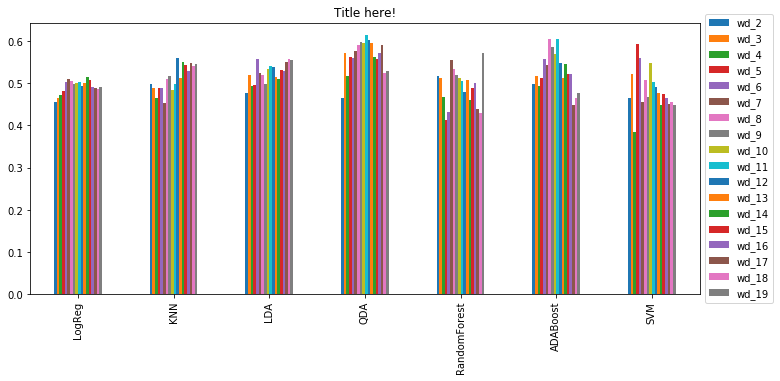

In [5]:

f = plt.figure(figsize=(12,5))
plt.title('Title here!', color='black')
k.plot(kind='bar',x=k.index, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Using window width of 11 as it gives the best performance

In [6]:
df = data_normalization(p,'min-max_rw',11)
(X_train,X_test,y_train,y_test) = split_data(df,0.9)
x = traditional_models(X_train, y_train, X_test, y_test)
x

,AUC,Accuracy
LogReg,0.503270,0.585938
KNN,0.498616,0.531250
LDA,0.540377,0.546875
QDA,0.613333,0.617188
RandomForest,0.417736,0.406250
ADABoost,0.605535,0.593750
SVM,0.502390,0.585938


QDA and AdaBoost achieve 60-61% accuracy/AUC

## Comparison with other normalization scheme
A comparison is done using MinMax without using rolling windows <br>
Standardization across the dataset or standardization across rolling windows was also compared with MinMax rolling window, with MinMax rolling window outperforming the rest

### Using Min-Max
Using MinMax without rolling window

In [7]:
#Using Min-Max
df = data_normalization(p,'min-max')
(X_train,X_test,y_train,y_test) = split_data(df,0.9)
df_minmax = traditional_models(X_train, y_train, X_test, y_test)
df_minmax

,AUC,Accuracy
LogReg,0.435824,0.589147
KNN,0.450348,0.589147
LDA,0.615690,0.410853
QDA,0.601043,0.426357
RandomForest,0.454568,0.449612
ADABoost,0.544191,0.589147
SVM,0.629096,0.558140


SVM achieves a 62% AUC on the test set

### PCA
Using PCA

In [8]:

df = data_normalization(p,'min-max')
(X_train,X_test,y_train,y_test) = split_data(df,0.9)
pca = PCA(n_components=5)
X_train_pca = pca.fit(X_train).transform(X_train)
X_test_pca = pca.fit(X_test).transform(X_test)
res_pca = traditional_models(X_train_pca,y_train,X_test_pca,y_test)
res_pca

,AUC,Accuracy
LogReg,0.588381,0.589147
KNN,0.594464,0.573643
LDA,0.623138,0.612403
QDA,0.593347,0.550388
RandomForest,0.456802,0.480620
ADABoost,0.548411,0.511628
SVM,0.578203,0.565891


## Neural network based approach
Used feed forward and LSTM.<br>
Used different number of layers for iteration with MinMax normalization across varios window sizes

In [48]:
##Feedforward Model
def make_model(num_nodes,num_layers,batch_size,epch,train_set,y_train,test_set,y_test):
    num_layers = num_layers-1
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=train_set.shape[1], activation='relu'))
    for i in range(num_layers):
        model.add(Dense(num_nodes, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    #p = model.fit(train_set, y_train,  epochs=epch, batch_size=batch_size, validation_data=(test_set, y_test),verbose=False)
    return model

In [49]:
#Feedforward NN
#Using rolling-window normalization
window = 11
df = data_normalization(p,'min-max_rw',window)
(X_train,X_test,y_train,y_test) = split_data(df,0.9)
train_set = X_train.as_matrix()
test_set = X_test.as_matrix()

x = make_model(50,4,32,250,train_set,y_train,test_set,y_test)
history = x.fit(train_set,y_train,epochs=100, validation_data=(test_set, y_test), verbose=False,
      callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=20, verbose=0, mode='min'),
                   keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
     )

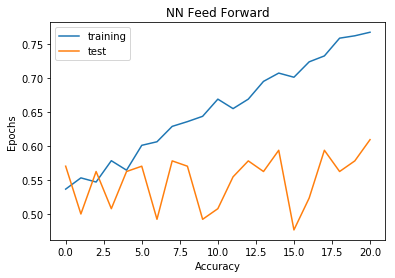

In [50]:
plt.plot(history.history['acc'],label='training')
plt.plot(history.history['val_acc'],label='test')
plt.title("NN Feed Forward")
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()

In [56]:
y_pred = x.predict_proba(X_test)
roc_auc_score(y_test, y_pred)

0.500125786163522

### LSTM
MinMax and standardization within varios window sizes was tried<br>
Used parameters that achieved maximum accuracy

In [59]:
#LSTM
#Min-Max rolling window
def gen_sequence(id_df, seq_length, seq_cols):
    scaler = MinMaxScaler()
    data_matrix = id_df[seq_cols].values
    enc_x = np.zeros((len(id_df)-seq_length+1, seq_length, len(seq_cols)))
    num_elements = id_df.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        enc_x[start] = scaler.fit_transform(data_matrix[start:stop, :])
        #Try standardizing
        #x = data_matrix[start:stop, :]
        #enc_x[start] = (x - x.mean()) / (x.max() - x.min())
    
    return enc_x

In [73]:
sequence_length = 2
c = p.columns.tolist()
c.remove('y')
seq_cols = c
X_dat = gen_sequence(p, sequence_length, seq_cols)
y = p['y'].values.reshape(-1,1)
y_dat = y[sequence_length-1:,]

#90% for training and 10% for testing
prop = 0.9
lm = int(np.floor(len(X_dat) * prop))
X_train = X_dat[0:lm]
y_train = y_dat[0:lm]
X_test = X_dat[lm:]
y_test = y_dat[lm:]
print("Training Set")
print(X_train.shape)
print(y_train.shape)
print("Test Set")
print(X_test.shape)
print(y_test.shape)

Training Set
(1156, 2, 25)
(1156, 1)
Test Set
(129, 2, 25)
(129, 1)


In [77]:
nb_features = X_train.shape[2]
nb_out = y_train.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=10,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

#model.add(TimeDistributed(Dense(units=nb_out, activation='sigmoid')))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 2, 10)             1440      
_________________________________________________________________
dropout_22 (Dropout)         (None, 2, 10)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 2, 50)             12200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total para

In [78]:
# fit the network
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=20, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Train on 1040 samples, validate on 116 samples
Epoch 1/100
 - 3s - loss: 0.6928 - acc: 0.5058 - val_loss: 0.6886 - val_acc: 0.5948
Epoch 2/100
 - 0s - loss: 0.6911 - acc: 0.5346 - val_loss: 0.6839 - val_acc: 0.5948
Epoch 3/100
 - 0s - loss: 0.6904 - acc: 0.5346 - val_loss: 0.6821 - val_acc: 0.5948
Epoch 4/100
 - 0s - loss: 0.6897 - acc: 0.5346 - val_loss: 0.6797 - val_acc: 0.5948
Epoch 5/100
 - 0s - loss: 0.6903 - acc: 0.5346 - val_loss: 0.6794 - val_acc: 0.5948
Epoch 6/100
 - 0s - loss: 0.6895 - acc: 0.5346 - val_loss: 0.6752 - val_acc: 0.5948
Epoch 7/100
 - 0s - loss: 0.6880 - acc: 0.5317 - val_loss: 0.6773 - val_acc: 0.5948
Epoch 8/100
 - 0s - loss: 0.6836 - acc: 0.5452 - val_loss: 0.6708 - val_acc: 0.5862
Epoch 9/100
 - 0s - loss: 0.6814 - acc: 0.5615 - val_loss: 0.6655 - val_acc: 0.5948
Epoch 10/100
 - 0s - loss: 0.6777 - acc: 0.5490 - val_loss: 0.6642 - val_acc: 0.6034
Epoch 11/100
 - 0s - loss: 0.6722 - acc: 0.5721 - val_loss: 0.6785 - val_acc: 0.5690
Epoch 12/100
 - 0s - loss: 

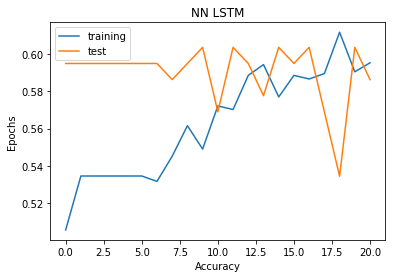

In [79]:
plt.plot(history.history['acc'],label='training')
plt.plot(history.history['val_acc'],label='test')
plt.title("NN LSTM")
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()

In [84]:
y_pred = model.predict_classes(X_test)
print(roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.42266633565044687
[[19 34]
 [39 37]]


## Creating Strong Buy/Sell Signals
Using the thresholds of the prediction probability, we can pick the signals that are extreme and choose to trade only on those days <br>
Using AdaBoost with a MinMax on 11 day rolling window

In [35]:
df = data_normalization(p,'min-max_rw',11)
(X_train,X_test,y_train,y_test) = split_data(df,0.9)
td = [1, 2]
trees = [2 ** x for x in range(1, 8)]
param_grid = {"n_estimators": trees,
              "max_depth": td,
              "learning_rate": [0.05]
             }

p = np.zeros((len(trees) * len(td), 3))
k = 0
for i in range(0, len(trees)):
    for j in range(0, len(td)):
        ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=td[j]),
                                 n_estimators=trees[i],
                                 learning_rate=.05)
        p[k, 0] = trees[i]
        p[k, 1] = td[j]
        p[k, 2] = np.mean(cross_val_score(ada, X_train, y_train, cv=5))
        k = k + 1
x = pd.DataFrame(p)
x.columns = ['ntree', 'depth', 'cv_score']
p = x.ix[x['cv_score'].argmax()]
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=p[1]),
                         n_estimators=int(p[0]), learning_rate = .05)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=64, random_state=None)

In [42]:
yhat = ada.predict_proba(X_test)

Text(0.5,1,'Prediction probability for binary classes')

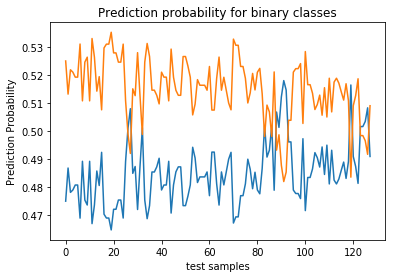

In [41]:
plt.plot(yhat)
plt.xlabel('test samples')
plt.ylabel('Prediction Probability')
plt.title('Prediction probability for binary classes')

We see that there are no extreme probabilities that can be used to find strong buy/sell signals

## Conclusion
The LSTM and feed forward NN do not increase the accuracy of prediction over traditional methods <br>
The traditional models and NNs are barely over the random classification thresholds <br>
There are no extreme probabilities of buy/sell signals<br>